# Finetuned Model
This file contains the code to finetune the `Salesforce/codet5p-220m` model. Evaluation will be done further down.

In [5]:
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig
from utils import load_tokenize_data, get_compute_metrics_fn, get_comparison_values

In [6]:
MODEL = 'Salesforce/codet5p-220m'
DATA_SIZE = -1
SAVE_PATH = 'saved_models/codet5p-test'
MAX_LENGTH = 250

## Load Model and Data

In [7]:
# Load model from `args.load`
tokenizer = AutoTokenizer.from_pretrained(MODEL, model_max_length=MAX_LENGTH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL, trust_remote_code=True)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
print(f"  ==> Loaded model from {MODEL}, model size {model.num_parameters()}")

# load dataset
data = load_tokenize_data(tokenizer, max_source_len=MAX_LENGTH, max_target_len=MAX_LENGTH, overwrite=True)

if DATA_SIZE != -1:
    data['train'] = data['train'].select([i for i in range(DATA_SIZE)])
    data['test'] = data['test'].select([i for i in range(DATA_SIZE)])

compute_metrics = get_compute_metrics_fn(tokenizer)
print('  ==> Loaded metrics fn')

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  ==> Loaded model from Salesforce/codet5p-220m, model size 222882048


Map (num_proc=64): 100%|██████████| 1000/1000 [00:04<00:00, 216.17 examples/s]


  ==> Loaded 3 datasets


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 27846.19 examples/s]


  ==> Saved to ./cache_data/code2code
  ==> Loaded metrics fn


## Training
The `Seq2SeqTrainingArguments` contain the configuration while the `trainer.train()` method starts the training process. With the default configuration one epoch takes rufley around 6-10 minutes on a Nvidia RTX 4060 (16GB).

In [8]:
training_args = Seq2SeqTrainingArguments(
    report_to='tensorboard',
    output_dir=SAVE_PATH,
    overwrite_output_dir=False,

    do_train=True,
    save_strategy='epoch',

    evaluation_strategy='epoch',
    predict_with_generate=True,
    # generation_max_length=MAX_LENGTH,
    generation_config=GenerationConfig(
        max_length=MAX_LENGTH,
        min_length=.5 * MAX_LENGTH,
        bos_token_id = tokenizer.bos_token_id,
        pad_token_id = tokenizer.pad_token_id
    ),

    num_train_epochs=10,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,

    learning_rate=5e-5,
    weight_decay=0.05,
    warmup_steps=200,

    logging_dir=SAVE_PATH,
    logging_first_step=True,
    logging_steps=10,
    save_total_limit=1,

    dataloader_drop_last=True,
    dataloader_num_workers=4,

    local_rank=-1,
    deepspeed=None,
    fp16=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    compute_metrics=compute_metrics,
    eval_dataset=data['validation']
)

pre_evaluation = trainer.evaluate(data['validation'], max_length=MAX_LENGTH)

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Trainer is attempting to log a value of "{'bleu': 0.0, 'precisions': [0.4732225645113523, 0.23615495694254665, 0.0026089297559540496, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.175219402392771, 'translation_length': 361293, 'reference_length': 307426}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'codebleu': 0.11888606363615359, 'ngram_match_score': 0, 'weighted_ngram_match_score': 0, 'syntax_match_score': 0.4161818481963752, 'dataflow_match_score': 0.05936240634823914}" of type <class 'dict'> for key "eval/codebleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [9]:
# do training
trainer.train()

final_checkpoint_dir = os.path.join(SAVE_PATH, "final_checkpoint")
model.save_pretrained(final_checkpoint_dir)
print(f'  ==> Finish training and save to {final_checkpoint_dir}')

Epoch,Training Loss,Validation Loss


## Evaluation

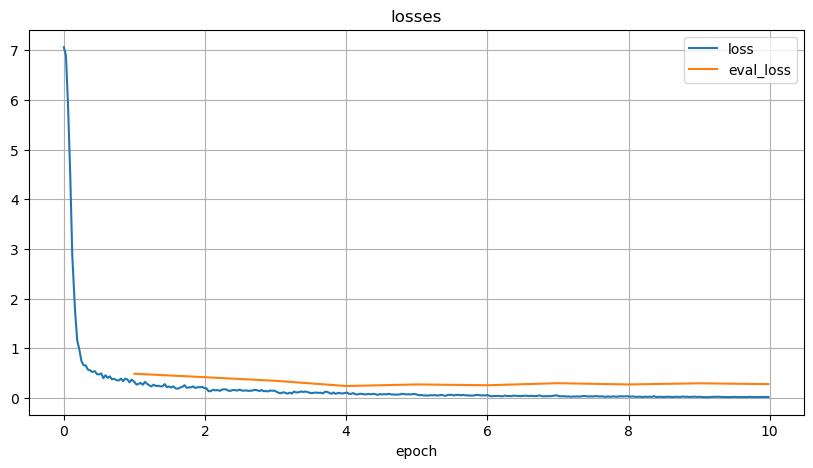

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

plt.figure(figsize=(10, 5))
plt.plot([data['epoch'] for data in history if 'loss' in data], [data['loss'] for data in history if 'loss' in data], label='loss')
plt.plot([data['epoch'] for data in history if 'eval_loss' in data], [data['eval_loss'] for data in history if 'eval_loss' in data], label='eval_loss')
plt.title('losses')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '/loss.png')

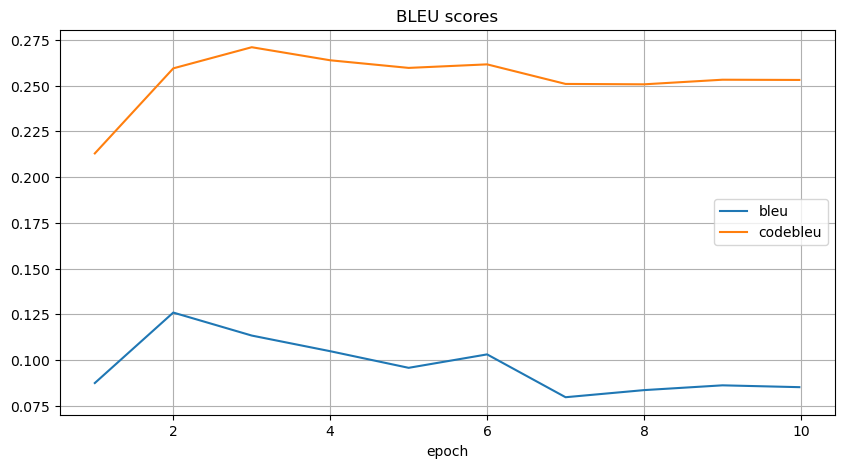

In [ ]:
eval_history = [data for data in history if 'eval_loss' in data]

plt.figure(figsize=(10, 5))

c_models, c_bleus = get_comparison_values('CodeBLEU')
plt.scatter([10 for i in c_bleus], c_bleus,  label='CodeBLEU')
for i, txt in enumerate(c_models):
    plt.annotate(txt, (10, c_bleus[i]))

plt.plot([data['epoch'] for data in eval_history], [data['eval_bleu']['bleu'] for data in eval_history], label='BLEU')
plt.plot([data['epoch'] for data in eval_history], [data['eval_codebleu']['codebleu'] for data in eval_history], label='CodeBLEU')

plt.title('BLEU scores')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '/bleu.png')

In [ ]:
from datasets import load_dataset
datasets = load_dataset("code_x_glue_cc_code_to_code_trans")
print(datasets)
print(len(max(datasets['train'], key=lambda x: len(x['java']))['java']))

DatasetDict({
    train: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 10300
    })
    validation: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 1000
    })
})
1398


In [ ]:
evaluation = trainer.evaluate(data['test'], max_length=20)
print(evaluation)

Trainer is attempting to log a value of "{'bleu': 0.08432722973400353, 'precisions': [0.1411016877135136, 0.0915158116776458, 0.07291025212449637, 0.05370990561813851], 'brevity_penalty': 1.0, 'length_ratio': 2.6108004969826055, 'translation_length': 58837, 'reference_length': 22536}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'codebleu': 0.24629220031450522, 'ngram_match_score': 0.002119331067831633, 'weighted_ngram_match_score': 0.01713642740182499, 'syntax_match_score': 0.141012909632572, 'dataflow_match_score': 0.8249001331557922}" of type <class 'dict'> for key "eval/codebleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.3058934211730957, 'eval_bleu': {'bleu': 0.08432722973400353, 'precisions': [0.1411016877135136, 0.0915158116776458, 0.07291025212449637, 0.05370990561813851], 'brevity_penalty': 1.0, 'length_ratio': 2.6108004969826055, 'translation_length': 58837, 'reference_length': 22536}, 'eval_codebleu': {'codebleu': 0.24629220031450522, 'ngram_match_score': 0.002119331067831633, 'weighted_ngram_match_score': 0.01713642740182499, 'syntax_match_score': 0.141012909632572, 'dataflow_match_score': 0.8249001331557922}, 'eval_runtime': 64.8724, 'eval_samples_per_second': 15.415, 'eval_steps_per_second': 1.927, 'epoch': 9.98}


In [19]:

from utils import load_tokenize_data, get_compute_metrics_fn

compute_metrics = get_compute_metrics_fn(tokenizer)

model = AutoModelForSeq2SeqLM.from_pretrained('saved_models/codet5p-tuned/final_checkpoint', trust_remote_code=True)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    compute_metrics=compute_metrics,
    eval_dataset=data['validation']
)

evaluation = trainer.evaluate(data['test'].select([i for i in range(10)]), max_length=MAX_LENGTH)
print(evaluation)

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Trainer is attempting to log a value of "{'bleu': 0.17052874218498862, 'precisions': [0.5307486631016043, 0.45135135135135135, 0.41120218579234974, 0.3784530386740331], 'brevity_penalty': 0.388087649471391, 'length_ratio': 0.5137362637362637, 'translation_length': 748, 'reference_length': 1456}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'codebleu': 0.30394005215876924, 'ngram_match_score': 0.28882697771731025, 'weighted_ngram_match_score': 0.5850664061014509, 'syntax_match_score': 0.18763796909492272, 'dataflow_match_score': 0.15422885572139303}" of type <class 'dict'> for key "eval/codebleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.4715164303779602, 'eval_bleu': {'bleu': 0.17052874218498862, 'precisions': [0.5307486631016043, 0.45135135135135135, 0.41120218579234974, 0.3784530386740331], 'brevity_penalty': 0.388087649471391, 'length_ratio': 0.5137362637362637, 'translation_length': 748, 'reference_length': 1456}, 'eval_codebleu': {'codebleu': 0.30394005215876924, 'ngram_match_score': 0.28882697771731025, 'weighted_ngram_match_score': 0.5850664061014509, 'syntax_match_score': 0.18763796909492272, 'dataflow_match_score': 0.15422885572139303}, 'eval_runtime': 4.8776, 'eval_samples_per_second': 2.05, 'eval_steps_per_second': 0.41}


In [ ]:
test_input = "public static void hello_world() { System.out.println(\"Hello World\"); }"
encoding = tokenizer(test_input, return_tensors="pt").to('cuda')
encoding['decoder_input_ids'] = encoding['input_ids'].clone()

outputs = model.generate(**encoding, max_length=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

public static void hello_world() { System.out.println("Hello World"); }public static void hello_world_1() { System.out.println("Hello World 1"); }



In [15]:
model.config

T5Config {
  "_name_or_path": "Salesforce/codet5p-220m",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "bos_token_id": 1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 1,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float16",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 32100
}